# Sitzung 10

Diese Skripte sind ausschließlich als Zusatz-Material gedacht. Speziell für diejenigen unter Euch, die einen Einblick in das Programmieren gewinnen wollen. Wenn Du es also leid bist repetitive Tätigkeiten auszuführen und das lieber einer Maschine überlassen willst, bist Du hier genau richtig. 

<span style="color:red"> Die Codes sind nicht für die Klausur relevant, genau genommen haben sie mit dem Lehrstuhl für Statistik **rein gar nichts** zu tun. </span>
***

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider

# Tinder und die Maximum-Likelihood Methode

## Anzahl Matches in einer Stunde
Aus einem vergangenem [Notebook](https://github.com/thsis/Statistik-I-II/blob/master/Statistik-II/sitzung-5.ipynb) wissen wir, dass die Anzahl matches innerhalb einer Stunde auf Tinder unter milden Annahmen poissonverteilt ist. 

$$X_i: \text{Anzahl matches auf Tinder innerhalb einer Stunde i, mit } X_i \sim Poiss(\lambda)$$

Zur Erinnerung, wir hatten zwei Dinge herausgefunden:
1. wir benötigen einen Erfahrungswert für die durchschnittliche Anzahl matches pro Stunde $\lambda$
2. sobald wir einen Wert für $\lambda$ haben, können wir die Wahrscheinlichkeit verschiedener Ergebnisse $x$ berechnen: $$P(X_i=x_i) = \frac{\lambda^{x_i}}{x_i!} \exp(-\lambda)$$

Was wir damals noch nicht geklärt hatten war, wie schätzen wir dieses $\lambda$ am besten? Denn ohne einen guten Wert für $\lambda$, werden wir keine realistischen Wahrscheinlichkeiten ausrechnen können. 

### Was ist das beste $\lambda$ das wir wählen können?


Um diese Frage zu beantworten, müssen wir zuerst ein paar Daten erheben. Nehmen wir an, dass wir dazu eine Woche lang, acht Stunden pro Tag auf Tinder ununterbrochen nach rechts wischen und unsere Beobachtungen notieren.

Wir interessieren uns für:
* die Anzahl Matches innerhalb einer Stunde.
* die Zeit die vergeht, bis wir unser erstes Match kriegen.

Wir erheben also 56 einzelne Datenpunkte und sehen die ersten 5 Ergebnisse dieser Woche auf Tinder in der Tabelle:

In [2]:
path = os.path.join("..", "data", "tinder_ML.csv")
tinder = pd.read_csv(path, index_col=["Zeit"])
tinder.head()

,Anzahl Matches,Zeit bis zum ersten Match
Zeit,,
2018-12-01 18:00:00,4,0.034403
2018-12-01 21:00:00,0,NaN
2018-12-01 23:00:00,1,0.177634
2018-12-02 02:00:00,2,0.348853
2018-12-02 05:00:00,3,0.056726


### Wie wahrscheinlich ist es, dass wir genau diese Daten bekommen?

Wir können diese Frage ein wenig umformulieren, um sie bequemer beantworten zu können. Wir suchen nämlich nach der **gemeinsamen Wahrscheinlichkeit** des beobachteten Ereignisses. Oder anders gesagt, wir fragen uns, wie wahrscheinlich war es, dass in der
1. Stunde 4 Matches und in der 
2. Stunde 0 Matches und in der
3. Stunde 1 Match und in der
4. Stunde 2 Matches und in der
5. Stunde 3 Matches und in der ...

Wir können das wieder in mathematische Ausdrücke umformulieren:
$$P(X=x_{Daten}) = P(\{X_1=4\} \cap \{X_2=0\} \cap \{X_3=1\} \cap \{X_4=2\} \cap \{X_5=3\} \cap \dots)$$

Und unter den vereinfachenden Annahmen
* $\color{blue}{\textit{identisch verteilte}}$ $X_i$ und
* $\color{orange}{unabhängige}$ $X_i$

Können wir die **gemeinsame Wahrscheinlichkeit** viel einfacher ausdrücken. <br>
Wenn alle $X_i$ $\color{orange}{unabhängig}$ sind, kann man die gemeinsame Wahrscheinlichkeit als Produkt schreiben:

$$
P(X=x_{Daten}) = P_1(\{X_1=4\} \cdot P_2(\{X_2=0\}) \cdot P_3(\{X_3=1\}) \cdot P_4(\{X_4=2\}) \cdot P_5(\{X_5=3\}) \cdot \dots
$$

Und wenn alle $X_i \color{blue}{\textit{ identisch verteilt}}$ sind, haben alle $X_i$ dieselbe Wahrscheinlichkeitsfunktion, also kann man die Subskripte weglassen:

\begin{align}
P(X=x_{Daten}) &= P(\{X_1=4\} \cdot P(\{X_2=0\}) \cdot P(\{X_3=1\}) \cdot P(\{X_4=2\}) \cdot P(\{X_5=3\}) \cdot \dots \\ 
&= \prod\limits_{i=1}^n P(X_i=x_i)
\end{align}

Jetzt können wir für $P$ eine Verteilungsfunktion einsetzen, die von einem Parameter abhängt (hier: $\lambda$)

$$
P(X=x_{Daten}) = \prod\limits_{i=1}^n P(X_i=x_i) = \prod\limits_{i=1}^n \frac{\lambda^{x_i}}{x_i!} \exp(-\lambda) = \exp(-n\lambda) \prod\limits_{i=1}^n \frac{\lambda^{x_i}}{x_i!} 
$$

Und damit haben wir einen Ausdruck, der nur noch von $\lambda$ abhängt, da die $x_i$ bereits eingetroffen sind. Man nennt diesen Ausdruck auch die **Likelihood**-Funktion.

In [3]:
def poisson_likelihood(lam):
    x_data = tinder["Anzahl Matches"].values
    n = len(x_data)
    L = np.exp(-n*lam) * np.prod([lam**xi / np.math.factorial(xi) for xi in x_data], axis=0)
    return L

### Zurück zur Frage: welches ist das beste $\lambda$?

Ganz einfach: wenn wir annehmen, das nichts furchtbar schief gelaufen ist und wir eine sehr unglückliche Stichprobe gezogen haben, dann sollten wir das $\lambda$ wählen, welches die **gemeinsame Wahrscheinlichkeit genau diese Stichprobe** zu ziehen maximiert.

In [9]:
def likelihood_viewer(lam=1.5):
    xaxis = np.linspace(0, lam, num=1000)
    yaxis = poisson_likelihood(xaxis)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    label = r"Likelihood für $\lambda$={:3.3}".format(lam)
    ax.plot(xaxis, yaxis, c="orange", label="Likelihood", lw=3)
    ax.plot(xaxis[-1], yaxis[-1], "o", c="red", label=label)
    
    ax.set_xlim([0, 6])
    ax.set_ylim([-1e-49, 4e-48])
    
    fig.suptitle(r"Likelihood für verschiedene $\lambda$", fontsize=16)
    plt.legend()

lambda_slider = FloatSlider(min=0.01, max=6, value=1.5, step=0.01, description=r"$\lambda$");

$$
L(\lambda) = \exp(-n\lambda)\prod\limits_{i=1}^n \frac{\lambda^{x_i}}{x_i !}
$$

In [10]:
interact(likelihood_viewer, lam=lambda_slider);

interactive(children=(FloatSlider(value=1.5, description='$\\lambda$', max=6.0, min=0.01, step=0.01), Output()…

Uns sollten mehrere Dinge auffallen:
* wenn $\lambda$ zu klein ist, nimmt auch die Likelihood-Funktion einen kleinen Wert an.
* wenn $\lambda$ zu groß ist, nimmt die Likelihood-Funktion einen Wert an der ebenfalls klein ist.
* wir suchen also nach einer Goldlöckchen-Lösung.

### Optimieren der Likelihood-Funktion

#### 0. Logarithmieren

Du dachtest wir würden gleich mit dem Ableiten beginnen, was? Die Funktion hier ist noch ok, wir müssten die Produkt und gegebenenfalls die Kettenregel anwenden - aber meine Güte, was wäre das für ein Aufwand!

Stattdessen verwenden wir eine monotone Transformation, die aus Produkten Summen macht. Und weil sie monoton ist, verändert sie die Lage des Maximums nicht. Wir logarithmieren die Likelihood-Funktion und bekommen so die **log-Likelihood-Funktion** $l$:

\begin{align}
l &= \log(L) = \log\left(\exp(-n\lambda) \prod\limits_{i=1}^n \frac{\lambda^{x_i}}{x_i!}\right) \\
  &= \log\left(\exp(-n\lambda)\right) +  \log\left( \prod\limits_{i=1}^n \frac{\lambda^{x_i}}{x_i!} \right) \\
  &= -n\lambda + \sum\limits_{i=1}^n \log\left( \frac{\lambda^{x_i}}{x_i!} \right)
\end{align}

Und die können wir relativ bequem ableiten

#### 1. Ableitung gleich Null setzen

\begin{align}
\frac{\partial l}{\partial \lambda} &= -n + \sum\limits_{i=1}^n \overbrace{\frac{1}{\frac{\lambda^{x_i}}{x_i!}}}^{\text{Äußere Ableitung}} \cdot \underbrace{\frac{x_i}{x_i!} \lambda^{x_i - 1}}_{\text{innere Ableitung}} \\
  &= -n + \sum\limits_{i=1}^n \frac{x_i}{\lambda^{x_i}} \lambda^{x_i - 1} = -n + \sum\limits_{i=1}^n \frac{x_i \color{red}{\lambda^{x_i}}}{\color{red}{\lambda^{x_i}}\cdot\lambda} \\
  &= -n + \frac{1}{\lambda} \sum\limits_{i=1}^n x_i \stackrel{!}{=} 0
\end{align}

Das ist unsere notwendige Bedingung um ein Maximum zu finden.

\begin{align}
0 &\stackrel{!}{=} -n + \frac{1}{\lambda} \sum\limits_{i=1}^n x_i \\
\Leftrightarrow \lambda_{ML}^* &= \frac{1}{n}\sum\limits_{i=1}^n x_i 
\end{align}

Und wir sehen, dass der beste Schätzer das arithmetische Mittel war.

In [17]:
def plot_likelihoods():
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 10), sharex=True)
    x = np.linspace(2, 4, num=1000)
    y1 = poisson_likelihood(x)
    y2 = np.log(y1)
    xbar = tinder["Anzahl Matches"].values.mean()
    label = r"$\lambda_{ML}^*" + "= {:3.2}$".format(xbar)

    ax[0].plot(x, y1, c="orange", lw=3)
    ax[0].plot([xbar, xbar], [-1, 1])
    ax[0].set_ylim([0, 4e-48])
    ax[0].set_title("Likelihood")
    ax[1].plot(x, y2, c="orange", lw=3)
    ax[1].plot([xbar, xbar], [-175, -100], label=label)
    ax[1].set_title("Log-Likelihood")
    ax[1].set_ylim([-120, -108])
    plt.legend()
    plt.tight_layout()
    return fig, ax

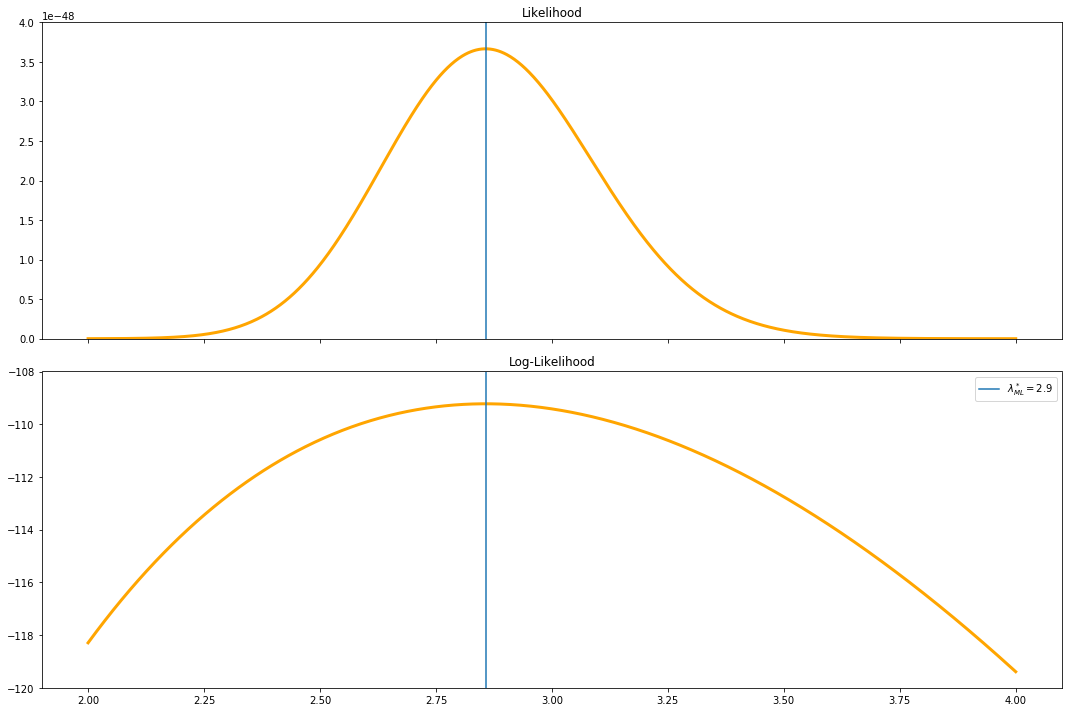

In [18]:
plot_likelihoods();

## Wartezeit auf das erste Match